In [42]:
# load in the correct modules
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import tqdm
import cmasher as cm
from matplotlib import rc
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
import warnings
warnings.filterwarnings('ignore')
import jax
from scipy import stats
import matplotlib.gridspec as grid
from matplotlib.colors import LogNorm

In [43]:
# LOAD THE DATA
path = '/Users/dhortadarrington/Documents/Master/data/allstar-dr17-StarHorse-Gaiadr3'
tb = fits.open(path)
data = tb[1].data 

In [44]:
# LOAD THE DATA FOR THE GC LIST IN APOGEE
path = '/Users/dhortadarrington/Documents/Master/data/'
file = 'GC_catalogo_14_mayo.fits'
# file = 'GC_DR16plus_nofeh.fits'

tb2 = fits.open(path+file)
data2 = tb2[1].data
gc_star_ids = data2.field('APOGEE_ID')
print('There are '+str(len(gc_star_ids))+' GC stars')

# LOAD THE DATA FOR THE GC LIST IN APOGEE
path = '/Users/dhortadarrington/Documents/Master/data/'
file = 'VAC_GC_DR17_synspec_rev1_beta.fits'
# file = 'GC_DR16plus_nofeh.fits'

tb3 = fits.open(path+file)
data3 = tb3[1].data
gc_star_ids_RPS = data3.field('APOGEE_ID')
print('There are '+str(len(gc_star_ids_RPS))+' GC stars')

There are 7562 GC stars
There are 7737 GC stars


In [45]:
apo_id = data['APOGEE_ID']
# Clean the initial data
mask_gcs = np.isin(list(apo_id),list(gc_star_ids))
mask_gcs2 = np.isin(list(apo_id),list(gc_star_ids_RPS))

In [46]:
starflag_bits = np.array(
    [
        0,  # BAD_PIXELS
        1,  # COMMISSIONING
        3,  # VERY_BRIGHT_NEIGHBOR
        16,  # SUSPECT_RV_COMBINATION
        17,  # SUSPECT_BROAD_LINES
        19,  # RV_REJECT
        21,  # MULTIPLE_SUSPECT
        22,  # RV_FAIL
    ]
)
starflag_bitmask = np.sum(2**starflag_bits)
starflag_mask = (data["STARFLAG"] & starflag_bitmask) == 0
starflag_mask.sum()

aspcapflag_bits = np.array(
    [
        23,  # STAR_BAD
    ]
)
aspcapflag_bitmask = np.sum(2**aspcapflag_bits)
aspcapflag_mask = (data["ASPCAPFLAG"] & aspcapflag_bitmask) == 0
aspcapflag_mask.sum()

536568

In [54]:
# create the parent mask
mask = (data['SNR']>50)&(data['LOGG']<3.5)&(data['LOGG']>0.)&(data['TEFF']>3500.)&(data['TEFF']<5500.)\
    &(mask_gcs==False)&(mask_gcs2==False)&(starflag_mask)&(aspcapflag_mask)&(data['ruwe']<1.4)&\
    (data['parallax']>0.2)&(data['parallax_over_error']>8.)

print('There are '+str(len(data[mask]))+' stars in the parent sample')


There are 176753 stars in the parent sample


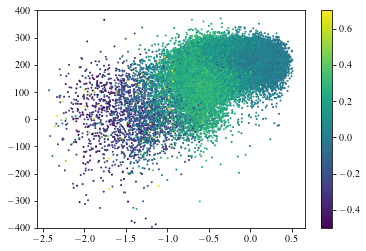

In [58]:
plt.scatter(data['FE_H'][mask],data['vxyz'][:,1][mask],s=1,c=data['AL_FE'][mask],vmin=-0.5,vmax=0.7)
plt.ylim(-400,400)
plt.colorbar()

416


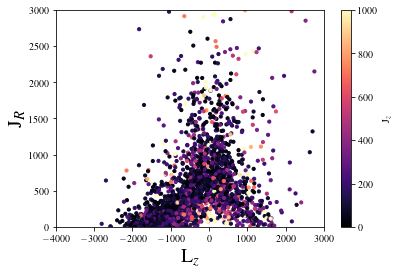

In [17]:
plt.scatter(data['L'][:,2][mask],data['actions'][:,0][mask],s=10,c=data['actions'][:,2][mask],cmap='magma',vmin=0,vmax=1000)
plt.xlim(-4000,3000)
plt.ylim(0,3000)
plt.colorbar(label=r'J$_{z}$')
plt.xlabel(r'L$_{z}$',fontsize=20)
plt.ylabel(r'J$_{R}$',fontsize=20)

mask_bar = (data['L'][:,2]<-1000)&(data['actions'][:,2]<200)
# &(data['actions'][:,0]<200)
print(len(data[mask&mask_bar]))


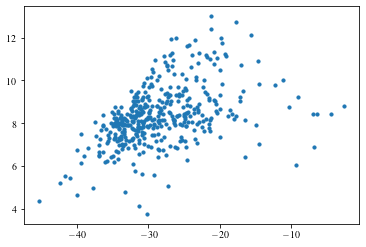

In [18]:
rgal = np.sqrt(data['xyz'][:,0]**2+data['xyz'][:,1]**2)

plt.scatter(data['freqs'][:,1][mask&mask_bar], rgal[mask&mask_bar],s=10)


(-0.2, 0.6)

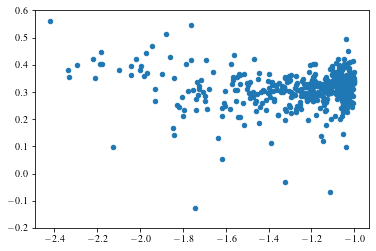

In [19]:
plt.scatter(data['FE_H'][mask&mask_bar],data['MG_FE'][mask&mask_bar],s=20)
plt.ylim(-0.2,0.6)


(-0.6, 0.6)

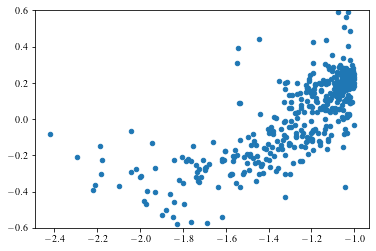

In [20]:
plt.scatter(data['FE_H'][mask&mask_bar],data['AL_FE'][mask&mask_bar],s=20)
plt.ylim(-0.6,0.6)

In [21]:
mask_GC = (data['FE_H']<-1.4)&(data['AL_FE']>0.2)
print(len(data[mask&mask_bar&mask_GC]))

3


Text(0, 0.5, '[Al/Fe]')

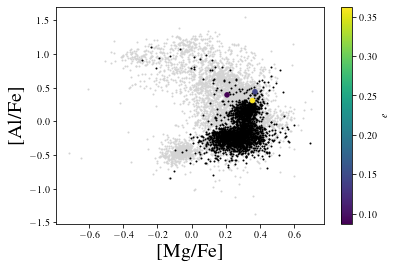

In [25]:

plt.scatter(data['MG_FE'][mask_gcs2],data['AL_FE'][mask_gcs2],s=1,c='lightgray')
plt.scatter(data['MG_FE'][mask],data['AL_FE'][mask],s=1,c='k')
plt.scatter(data['MG_FE'][mask&mask_bar&mask_GC],data['AL_FE'][mask&mask_bar&mask_GC],s=20,c=data['ecc'][mask&mask_bar&mask_GC])
plt.colorbar(label=r'$e$')
plt.xlabel('[Mg/Fe]',fontsize=20)
plt.ylabel('[Al/Fe]',fontsize=20)
                                                                                                         




Text(0, 0.5, '[N/Fe]')

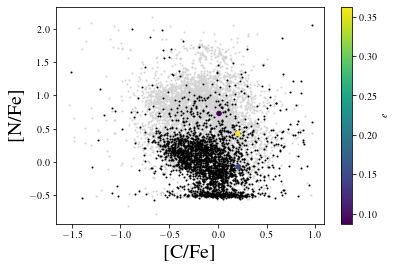

In [26]:

plt.scatter(data['C_FE'][mask_gcs2],data['N_FE'][mask_gcs2],s=1,c='lightgray')
plt.scatter(data['C_FE'][mask],data['N_FE'][mask],s=1,c='k')
plt.scatter(data['C_FE'][mask&mask_bar&mask_GC],data['N_FE'][mask&mask_bar&mask_GC],s=20,c=data['ecc'][mask&mask_bar&mask_GC])
plt.colorbar(label=r'$e$')
plt.xlabel('[C/Fe]',fontsize=20)
plt.ylabel('[N/Fe]',fontsize=20)


In [31]:
mask_nrich = (data['FE_H']<-1)&(data['N_FE']>0.6)&(data['C_FE']<-0.1)
print(len(data[mask&mask_nrich]))

101


8


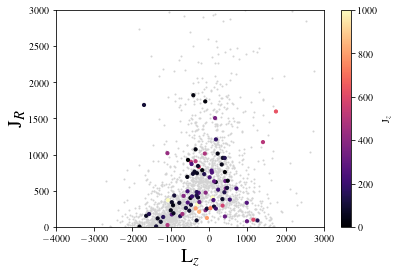

In [36]:
plt.scatter(data['L'][:,2][mask],data['actions'][:,0][mask],s=1,c='lightgray')
plt.scatter(data['L'][:,2][mask&mask_nrich],data['actions'][:,0][mask&mask_nrich],s=10,c=data['actions'][:,2][mask&mask_nrich],cmap='magma',vmin=0,vmax=1000)
plt.xlim(-4000,3000)
plt.ylim(0,3000)
plt.colorbar(label=r'J$_{z}$')
plt.xlabel(r'L$_{z}$',fontsize=20)
plt.ylabel(r'J$_{R}$',fontsize=20)

mask_bar = (data['L'][:,2]<-1000)&(data['actions'][:,2]<200)
print(len(data[mask&mask_nrich&mask_bar]))


Text(0, 0.5, '[Al/Fe]')

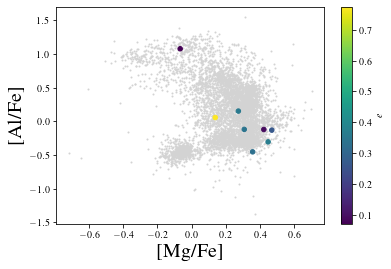

In [37]:

plt.scatter(data['MG_FE'][mask_gcs2],data['AL_FE'][mask_gcs2],s=1,c='lightgray')
plt.scatter(data['MG_FE'][mask&mask_bar&mask_nrich],data['AL_FE'][mask&mask_bar&mask_nrich],s=20,c=data['ecc'][mask&mask_bar&mask_nrich])
plt.colorbar(label=r'$e$')
plt.xlabel('[Mg/Fe]',fontsize=20)
plt.ylabel('[Al/Fe]',fontsize=20)
                                       

Text(0, 0.5, '[N/Fe]')

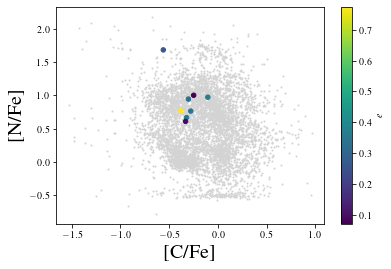

In [38]:

plt.scatter(data['C_FE'][mask_gcs2],data['N_FE'][mask_gcs2],s=1,c='lightgray')
plt.scatter(data['C_FE'][mask&mask_bar&mask_nrich],data['N_FE'][mask&mask_bar&mask_nrich],s=20,c=data['ecc'][mask&mask_bar&mask_nrich])
plt.colorbar(label=r'$e$')
plt.xlabel('[C/Fe]',fontsize=20)
plt.ylabel('[N/Fe]',fontsize=20)


Text(0, 0.5, '[Al/Fe]')

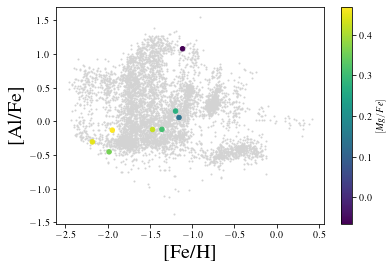

In [39]:

plt.scatter(data['FE_H'][mask_gcs2],data['AL_FE'][mask_gcs2],s=1,c='lightgray')
plt.scatter(data['FE_H'][mask&mask_bar&mask_nrich],data['AL_FE'][mask&mask_bar&mask_nrich],s=20,c=data['MG_FE'][mask&mask_bar&mask_nrich])
plt.colorbar(label=r'$[Mg/Fe]$')
plt.xlabel('[Fe/H]',fontsize=20)
plt.ylabel('[Al/Fe]',fontsize=20)
                                    

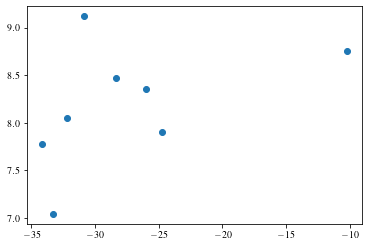

In [41]:
plt.scatter(data['freqs'][:,1][mask&mask_bar&mask_nrich],rgal[mask&mask_bar&mask_nrich])
